<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/interferometro_michelson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importazione dei dati
importo il dataset dell'esperimento

In [0]:
import pandas as pd
import numpy as np
import scipy.constants as cost

# !pip install uncertainties
from uncertainties import unumpy

import matplotlib.pyplot as plt
plt.style.use("ggplot")
plt.rcParams['axes.facecolor'] = '#f7f9fc'

In [30]:
path = "https://www.dropbox.com/s/hcbw9p2c8utgwdq/Dati_Michelson-v4.xlsx?dl=1"
# inserisco i dati in un dataset pandas.
data = pd.read_excel(path, names=[
    "dl", "vmax", "svmax", "vmin", "svmin"
  ]
)
data['sdl'] = 0.1 # 1mm uncertainty on lengths
data['tau'] = data['dl']*2/29.98 # [ns]
data['stau'] = data['sdl']*2/29.98 # [ns]
vmax = unumpy.uarray(data.vmax, data.svmax)
vmin = unumpy.uarray(data.vmin, data.svmin)
tau = unumpy.uarray(data.tau, data.stau)

vis = (vmax - vmin) / (vmax + vmin) # automatically evaluates uncertainties
data['vis'] = unumpy.nominal_values(vis)
data['svis'] = unumpy.std_devs(vis)
print(data)

       dl   vmax  svmax  vmin  ...       tau      stau       vis      svis
0    -5.1   77.2    3.3   9.0  ... -0.340227  0.006671  0.791183  0.028171
1    -2.5  113.4    4.4   7.4  ... -0.166778  0.006671  0.877483  0.019177
2     0.0   79.4    3.4   0.2  ...  0.000000  0.006671  0.994975  0.025063
3     2.5   59.4    2.8   2.7  ...  0.166778  0.006671  0.913043  0.034113
4     5.0   87.4    3.6   8.2  ...  0.333556  0.006671  0.828452  0.023843
5     7.5   87.4    3.6  13.0  ...  0.500334  0.006671  0.741036  0.025993
6     8.5   82.4    3.5  18.2  ...  0.567045  0.006671  0.638171  0.027479
7    10.0   70.6    3.1  21.0  ...  0.667111  0.006671  0.541485  0.031077
8    12.5   61.0    2.8  25.0  ...  0.833889  0.006671  0.418605  0.035212
9    13.5   69.4    3.1  34.2  ...  0.900600  0.006671  0.339768  0.032546
10   15.0   57.4    2.7  39.8  ...  1.000667  0.006671  0.181070  0.035101
11   17.5   44.6    2.3  33.8  ...  1.167445  0.006671  0.137755  0.038500
12   20.0   51.0    2.5  

Per calcolare la visibilità avrò bisogno di mettere a confronto il minimo ed il massimo dell'intensità, creo quindi una funzione per farlo.

In [0]:
import scipy.odr as odr
from scipy.stats import kstest

''' Performs the fit
Needed Parameters (key-word):
  function: function with 2 arguments:
    array-like object for parameters (float-like)
    array-like object for variables (float-like)
  par0: array-like object for parameters prior (float-like)
  par_names: array-like object for parameters prior (string)
  file_name: csv with data
Returns:
  tuple with array of parameters and pvalue
'''
def fit(function=None, par0=None, par_names=None,
        x=None, y=None, sx=None, sy=None,
        xlabel="", ylabel="", title="", xres = 100, ax1=None, ax2=None):

  fit_data = odr.RealData(x, y=y, sx=sx, sy=sy)
  model = odr.Model(function)
  fit = odr.ODR(fit_data, 
                model, 
                beta0=par0)
  out = fit.run()

  par = out.beta
  par_s = out.sd_beta
  for i in range(len(par_names)):
    print(f'{par_names[i]} : {par[i]:.3f} +- {par_s[i]:.3f}')

  ax1.errorbar(x, y, xerr=sx, yerr=sy,
    ecolor='black', fmt='o', color='black', markersize=2
  )
  d_x = max(x)-min(x)
  x = np.linspace(min(x)-d_x/10, max(x)+d_x/10, xres)
  d_y = max(y)-min(y)
  ax1.set_ylim(min(y)-d_y/10, max(y)+d_y/10)
  ax1.plot(x, function(par, x), color='blue')
  ax1.set(xlabel=xlabel, ylabel=ylabel, title=title)
  '''
  kolmogorov-smirnov test on normalized residuals is performed
  it tests the similarity between normalized residuals and a normalized gaussian
  this similarity implies a reasonable belief in goodnes of fit and
  correct estimation of uncertainties
  if pvalue is > 0.05 the fit is accepted
  '''
  y_res_norm = out.eps/sy
  ax2.hist(y_res_norm)
  ax2.set_title("Residuals histogram")
  pvalue = kstest(y_res_norm, 'norm').pvalue
  print(f"p_value: {pvalue:.3f}")
  return out

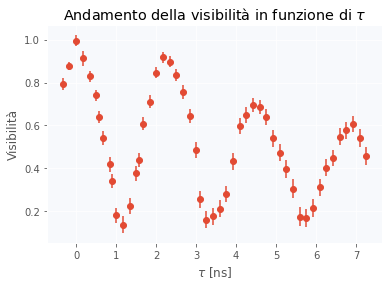

In [42]:
fig, ax = plt.subplots()
ax.set(title=r'Andamento della visibilità in funzione di $\tau$',
     ylabel = 'Visibilità', xlabel = r'$\tau$ [ns]')
ax.errorbar(data.tau, data.vis, xerr=data.stau, yerr=data.svis, fmt="o")
plt.show()
fig.savefig("vis.png")

sigma : 0.149 +- 0.009
Domega : 2.748 +- 0.011
p_value: 0.222


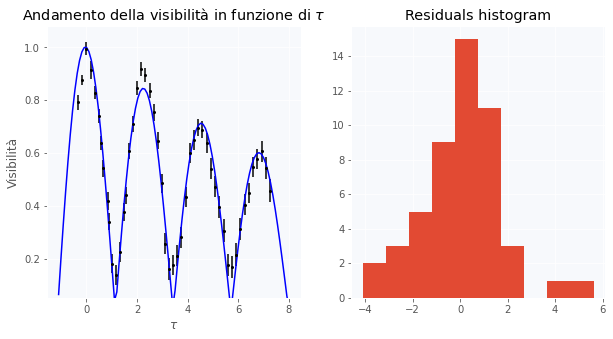

In [57]:
def vis(N=2):
  def func(par, t):
      sigma, Domega = par
      y = np.exp(-sigma*t/2)/N * \
        np.abs(
            np.sin(N*Domega*t/2) / \
              (np.sin(Domega*t/2)+1e-10) # for unmerical stability
        )
      return y
  return func
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
out = fit(vis(), x = data.tau, y = data.vis, sy = data.svis, sx = data.stau,
    par0 = [0.16, 2.7], par_names=['sigma', 'Domega'],
    ax1=axs[0], ax2=axs[1], xlabel=r"$\tau$", ylabel="Visibilità", 
    title=r'Andamento della visibilità in funzione di $\tau$')

In [0]:
  par = fitted.beta
  par_s = fitted.sd_beta
  tau = 2/par[0]
  stau = par_s[0]/(par[0]*par[0])
  print(f'tau value: ({tau : .1f} +- {stau: .1f})ns')

tau value: ( 13.5 +-  0.5)ns


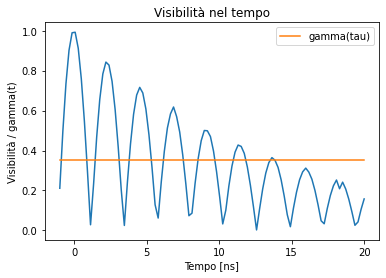

In [0]:
x = np.linspace(-1, 20, 100)
plt.plot(x, rs(par, x))
plt.plot(x, [rs(par, tau)]*len(x), label = 'gamma(tau)')
plt.title('Visibilità nel tempo')
plt.xlabel('Tempo [ns]')
plt.ylabel('Visibilità / gamma(t)')
plt.legend()

In [0]:
# lunghezza della cavità
L = cost.pi*cost.c/(par[2]*1e9)
sL = cost.pi*cost.c*par_s[2]*1e9/(par[2]*1e9)**2
print(f'Lunghezza della cavità del laser: ({L:.3f} +- {sL:.3f})m')

Lunghezza della cavità del laser: (0.343 +- 0.001)m


sigma : 0.017 +- 0.006
N : 2.999 +- 0.004
Domega : 2.741 +- 0.018


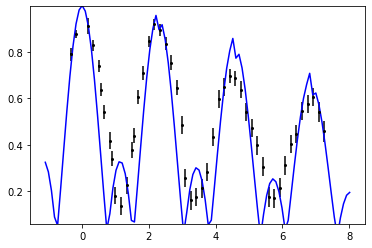

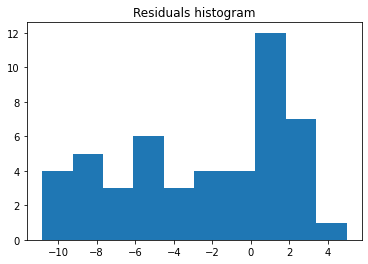

p_value: 0.000


In [0]:
#verifica dell'ipotesi dei 3 modi
def rs(par, t):
    sigma = par[0]
    N = par[1]
    Domega = par[2]
    y = np.exp(-sigma*t**2/2)/N*np.abs(np.sin(N*Domega*t/2)/np.sin(Domega*t/2))
    return y
fit(rs, x = data['tempo [ns]'], y = data['Visibilità'], sy = data['sigma[V]'], sx = data['sigma[t] [ns]'],
    par0 = [0.16, 3, 2.76], par_names=['sigma', 'N', 'Domega'])